## init

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

## create embedding

In [119]:
import os

fake_num = 50


path = "./code"
id_list = []
code_list = []

file_lst = os.listdir(path)
for file in file_lst:
    id_list.append(file[:-len(".py")])
    filepath = path + '/' + file
    with open(filepath) as f:
        code_list.append(f.read())

In [120]:
## 가짜 코드 생성
fake_id_list = []
code_list = code_list * fake_num
for id in range(fake_num):
    fake_id_list.extend(map(lambda x: x+str(id), id_list))

id_list = fake_id_list
len(id_list)

250

In [4]:
batch_size = 64
max_len = 40
result = []

for idx in range(0, len(id_list), batch_size):
    batch_input = tokenizer.batch_encode_plus(
        code_list[idx:idx+batch_size],
        return_tensors="pt",
        max_length = max_len,
        truncation = True,
        pad_to_max_length = True,
        padding=True).to(device)
    batch_output = model(**batch_input)
    cls_embedding = batch_output.last_hidden_state[:, 0, :]
    result.append(cls_embedding.to('cpu'))
    del batch_input
    del batch_output
    del cls_embedding

    ## TODO 데이터 커지면 oom 뜸


In [75]:
cls_embedding = torch.cat([r for r in result]).detach().numpy()
cls_embedding.shape

(250, 768)

## PCA

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cls_scaled= StandardScaler().fit_transform(cls_embedding)

pca = PCA(n_components=0.99)
pca.fit(cls_scaled)
cls_pca = pca.transform(cls_scaled)
cls_pca.shape

(250, 4)

## TSNE

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
cls_tsne = tsne.fit_transform(cls_pca)
cls_tsne.shape

/home/tako/anaconda3/envs/junyoung/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tako/anaconda3/envs/junyoung/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(250, 2)

## Mean shift

In [82]:
from sklearn.cluster import MeanShift
import numpy as np
from sklearn.cluster import estimate_bandwidth

bandwidth = int(estimate_bandwidth(cls_tsne))
print('bandwidth 값:', bandwidth)
meanshift= MeanShift(bandwidth=bandwidth)
label_list= meanshift.fit_predict(cls_tsne)
cluster_label = np.unique(label_list)
print('cluster labels 유형:', cluster_label)

bandwidth 값: 24
cluster labels 유형: [0 1 2 3]


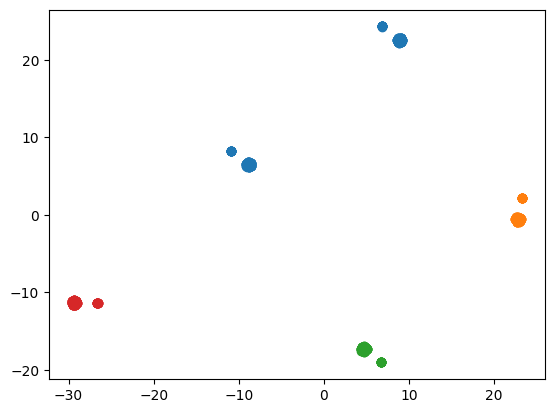

In [89]:
import matplotlib.pyplot as plt

clustered_cls = []
index_list = np.array([i for i in range(len(label_list))])
for label in cluster_label:
    labeled = cls_tsne[label_list == label]
    plt.scatter(labeled[:, 0], labeled[:, 1], label = label)
    clustered_cls.append(index_list[label_list == label])


In [124]:
clustered_cls

[array([  0,   2,   5,   7,  10,  12,  15,  17,  20,  22,  25,  27,  30,
         32,  35,  37,  40,  42,  45,  47,  50,  52,  55,  57,  60,  62,
         65,  67,  70,  72,  75,  77,  80,  82,  85,  87,  90,  92,  95,
         97, 100, 102, 105, 107, 110, 112, 115, 117, 120, 122, 125, 127,
        130, 132, 135, 137, 140, 142, 145, 147, 150, 152, 155, 157, 160,
        162, 165, 167, 170, 172, 175, 177, 180, 182, 185, 187, 190, 192,
        195, 197, 200, 202, 205, 207, 210, 212, 215, 217, 220, 222, 225,
        227, 230, 232, 235, 237, 240, 242, 245, 247]),
 array([  3,   8,  13,  18,  23,  28,  33,  38,  43,  48,  53,  58,  63,
         68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128,
        133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193,
        198, 203, 208, 213, 218, 223, 228, 233, 238, 243, 248]),
 array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
         66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
    

## Create Group

In [127]:
from itertools import zip_longest

min_group_member = 4
max_group_member = 8
group_list = np.array([-1] * len(id_list))
group_member_num = min(8, max(4, len(cluster_label)))
group_num = 0
cnt = 0


for member_list in zip_longest(*clustered_cls):
    for member in member_list:
        if member == None:
            continue

        cnt += 1
        group_list[member] = group_num

        if cnt % group_member_num == 0:
            group_num += 1


## Create Data

id - id_list[n]
x - cls_tsne[n:0]
y - cls_tsne[n:1]
label - label_list[n]
group - sdfdf
code - code_list[n]

In [ ]:


# interface CodeData {
# 	id: number; // 사용자 고유 아이디 (Random)
# 	name: string // 사용자 이름 (윤세린, 최지원, 김준영, 장미)
# 	x: number; // Scatterplot 상에서 x 좌표 
# 	y: number; // Scatterplot 상에서 y 좌표 
# 	label: string; // Cluster 이름 (A, B, C...)
# 	group: string; // 그룹 이름 (가, 나, 다)
# 	code: string; // Raw code string 
# }

# interface Response {
# 	data: CodeData[];
# 	centroid: string[];
# 	labels: string[];
# 	groups: string[];
# };